In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import read_tree as rt

import sys


Welcome to JupyROOT 6.13/03


In [5]:
%matplotlib inline

In [12]:
from sklearn.utils import shuffle

In [7]:
#utworze teraz dane jakies
def kolko_w_kolku(sig1=0.4,sig2=0.6,R2=1.,N=1000):
    """to ma utworzyc dane ktore posluza mi do sprawdzenia czy i jak dziala model"""
    features=[]
    labels=[]
    for i in range(N):
        x=np.random.normal(0,sig1)
        y=np.random.normal(0,sig1)
        features.append([x,y])
        labels.append(0)
    for i in range(N):
        alpha=np.random.uniform()*2*np.pi
        delr=np.random.normal(0,sig2)
        r=R2+delr
        x=np.cos(alpha)*r
        y=np.sin(alpha)*r
        features.append([x,y])
        labels.append(1)
    features=np.array(features)
    labels=np.array(labels)
    features,labels=shuffle(features,labels)
    return features,labels

In [9]:
def rysoj_dane(f,l):
    plt.clf()
    plt.scatter(f[:,0],f[:,1],c=l,s=5)

In [10]:
"""
do creatora dajemy sobie nazwe pliku (sciezke) oraz slownik typu {'czterowektor': (4,'f'),'intowa_wlasnosc': (1,'i'),
...}
to znaczy nazwe, ile to jest liczb, jakiego typu. Obsluguje na razie jedynie 'f' oraz 'i' to 
jest float oraz int
nie mozna uzyc jako klucz 'label', bo to jest wykorzystywana nazwa.


funkcja wpisz bierze jako argument generator ktory zwraca jak na niego podziałać next() cos typu 
({"czterowektor":[1.,2.,3.,4.], ...},1) gdzie 1 jest labelem, label jest intem.
. oczywiście klucze slownika zgadzają się 
z kluczami ze slownika ktorego uzylismy do kreatora.

dataset wczytany metoda wczytaj dataset jest juz w postaci wygodnej dla mnie to znaczy 
slownik feature, label
"""


class Io_tf_binary_v2:
    def __init__(self,nazwa_pliku,slownik):
        self.plik=nazwa_pliku
        self.typy=slownik
        #self.cos=Io_tf_binary.wrap_int64([5])
    

    """
    To moze sobie czytac ktos kto chce zmieniac wnetrznosci tej klasy
    Nie polecam
    
    Teraz ta funkcja wpisz jest ważna. ona bierze po jednym przypadku testowym, 
    ( to jest ta petla for i in range()) i go zapisuje. trzeba zwracac 
    uwage na to jakiego typu sa zapisywane rzeczy. mozna oczywiscie zrobic slownik
    data dluzszym, jesli to w jakis sposob ulatwi nam myslenie o naszych danych. 
    Bo te nasze dane to bedzie slownik list, w ktorych to listach rzeczy maja 
    juz taki sam typ, a klucze to beda jakies opisowe nazwy.
    np 

    data={
    'czteroped_lewej_nogi_czy_cos': wrap_float64(cztero), # gdzie cztero to jest tensor floatow o shape (4,)
    # reszta rzeczy

    }

    Jak byscie chcieli jako wartosci miec stringi to musicie pomyslec jak zrobic wrapy dla stringow. oczywiscie
    nie znajdziecie zadnej dokumentacji.

    UWAGA 
    w tym slowniku data musi byc to co klasyfikujemy oznaczone przy pomocy 'label' bo inaczej sie  wywali program.





    """


    def wpisz(self,generator):
        """tworzy ten nasz dataset w pliku out_path """
        
        def wrap_int64(value):
            """lista intow musi wlesc"""
            return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
        def wrap_float64(value):
            """lista floatow musi wlesc"""
            return tf.train.Feature(float_list=tf.train.FloatList(value=value))
        
        #f,l=kolko_w_kolku() #mozna zmienic jak sie podoba
        def data_slownik(f,l):
            wyrzut={}
            for k in self.typy.keys():
                if self.typy[k][1]=='f':
                    wyrzut[k]=wrap_float64(np.array(f[k]).reshape((-1,)))
                else:
                    wyrzut[k]=wrap_int64(np.array(f[k]).reshape((-1,)))
            wyrzut['label']=wrap_int64([l])
            return wyrzut
                    
        with tf.python_io.TFRecordWriter(self.plik) as writer:
            for f,l in generator:
                #feature=f[i]
                #label=l[i]
                #data = {
                 #    'feature': wrap_float64(feature),
                #  'label': wrap_int64([label])
                   #     }
                data=data_slownik(f,l)
                # Wrap the data as TensorFlow Features.
                feature = tf.train.Features(feature=data)

                # Wrap again as a TensorFlow Example.
                example = tf.train.Example(features=feature)

                # Serialize the data.
                serialized = example.SerializeToString()

                # Write the serialized data to the TFRecords file.
                writer.write(serialized)

        
        
        
        
        
        
                
   
    
    def wczytaj_dataset(self):
        
        def zeslownikoj(x):
            keys=list(x.keys())
            f={}
            for k in keys:
                if not k=='label':
                    f[k]=x[k]
            return f,x['label']
        def features_generoj():
            wyrzut={}
            for k in self.typy.keys():
                if self.typy[k][1]=='f':
                    wyrzut[k]=tf.FixedLenFeature([self.typy[k][0]], tf.float32)
                else:
                    wyrzut[k]=tf.FixedLenFeature([self.typy[k][0]], tf.int64)
            wyrzut['label']=tf.FixedLenFeature([], tf.int64)
            return wyrzut

        def parse(serialized):
            
            # Define a dict with the data-names and types we expect to
            # find in the TFRecords file.
            # It is a bit awkward that this needs to be specified again,
            # because it could have been written in the header of the
            # TFRecords file instead.
            """
            features = \
                {
                    'dwuwektor': tf.FixedLenFeature([2], tf.float32),#z jakiegos powodu to jest float32, nie wiem czemu
                    'label': tf.FixedLenFeature([], tf.int64)
                }
            """
            features=features_generoj()
            print(features)

            # Parse the serialized data so we get a dict with our data.
            parsed_example = tf.parse_single_example(serialized=serialized,
                                                     features=features)


            return zeslownikoj(parsed_example)

        dataset = tf.data.TFRecordDataset(self.plik)
        dataset = dataset.map(parse)
        return dataset
    
    
    
    
    
    

In [88]:
"""
do creatora dajemy sobie nazwe pliku (sciezke) oraz slownik typu {'czterowektor': (4,'f'),'intowa_wlasnosc': (1,'i'),
...}
to znaczy nazwe, ile to jest liczb, jakiego typu. Obsluguje na razie jedynie 'f' oraz 'i' to 
jest float oraz int
nie mozna uzyc jako klucz 'label', bo to jest wykorzystywana nazwa.


funkcja wpisz bierze jako argument generator ktory zwraca jak na niego podziałać next() cos typu 
({"czterowektor":[1.,2.,3.,4.], ...},1) gdzie 1 jest labelem, label jest intem.
. oczywiście klucze slownika zgadzają się 
z kluczami ze slownika ktorego uzylismy do kreatora.

dataset wczytany metoda wczytaj dataset jest juz w postaci wygodnej dla mnie to znaczy 
slownik feature, label
"""


class Io_tf_binary_stary:
    def __init__(self,nazwa_pliku,slownik,co_ile_flush_file=10):
        self.co_ile=co_ile_flush_file
        self.plik=nazwa_pliku
        self.typy=slownik
        for k in self.typy.keys():
            assert self.typy[k][1] in ['f','i']
            assert self.typy[k][0]>0 
            assert type(self.typy[k][0])==int or type(self.typy[k][0])==int ==numpy.int64
        self.writer= tf.python_io.TFRecordWriter(self.plik)
        self.liczba_wrzuconych=0
        
        #self.cos=Io_tf_binary.wrap_int64([5])
    
    def close(self):
        self.writer.close()
    

    """
    To moze sobie czytac ktos kto chce zmieniac wnetrznosci tej klasy
    Nie polecam
    
    Teraz ta funkcja wpisz jest ważna. ona bierze po jednym przypadku testowym, 
    ( to jest ta petla for i in range()) i go zapisuje. trzeba zwracac 
    uwage na to jakiego typu sa zapisywane rzeczy. mozna oczywiscie zrobic slownik
    data dluzszym, jesli to w jakis sposob ulatwi nam myslenie o naszych danych. 
    Bo te nasze dane to bedzie slownik list, w ktorych to listach rzeczy maja 
    juz taki sam typ, a klucze to beda jakies opisowe nazwy.
    np 

    data={
    'czteroped_lewej_nogi_czy_cos': wrap_float64(cztero), # gdzie cztero to jest tensor floatow o shape (4,)
    # reszta rzeczy

    }

    Jak byscie chcieli jako wartosci miec stringi to musicie pomyslec jak zrobic wrapy dla stringow. oczywiscie
    nie znajdziecie zadnej dokumentacji.

    UWAGA 
    w tym slowniku data musi byc to co klasyfikujemy oznaczone przy pomocy 'label' bo inaczej sie  wywali program.





    """


    def wpisz(self,features,label):
        """tworzy ten nasz dataset w pliku out_path 
        tu format jest taki jak byl na poczatku to znaczy taki slownik"""
        f=features
        l=label
        def wrap_int64(value):
            """lista intow musi wlesc"""
            return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
        def wrap_float64(value):
            """lista floatow musi wlesc"""
            return tf.train.Feature(float_list=tf.train.FloatList(value=value))
        
        #f,l=kolko_w_kolku() #mozna zmienic jak sie podoba
        def data_slownik(f,l):
            wyrzut={}
            for k in self.typy.keys():
                if self.typy[k][1]=='f':
                    wyrzut[k]=wrap_float64(np.array(f[k]).reshape((-1,)))
                else:
                    wyrzut[k]=wrap_int64(np.array(f[k]).reshape((-1,)))
            wyrzut['label']=wrap_int64([l])
            return wyrzut
                    
        
            
        #feature=f[i]
        #label=l[i]
        #data = {
         #    'feature': wrap_float64(feature),
        #  'label': wrap_int64([label])
           #     }
        data=data_slownik(f,l)
        # Wrap the data as TensorFlow Features.
        feature = tf.train.Features(feature=data)

        # Wrap again as a TensorFlow Example.
        example = tf.train.Example(features=feature)

        # Serialize the data.
        serialized = example.SerializeToString()

        # Write the serialized data to the TFRecords file.
        self.writer.write(serialized)
        self.liczba_wrzuconych+=1
        if self.liczba_wrzuconych%self.co_ile==0:
            self.writer.flush()

        
        
        
        
        
        
                
   
    
    def wczytaj_dataset(self):
        
        def zeslownikoj(x):
            keys=list(x.keys())
            f={}
            for k in keys:
                if not k=='label':
                    f[k]=x[k]
            return f,x['label']
        def features_generoj():
            wyrzut={}
            for k in self.typy.keys():
                if self.typy[k][1]=='f':
                    wyrzut[k]=tf.FixedLenFeature([self.typy[k][0]], tf.float32)
                else:
                    wyrzut[k]=tf.FixedLenFeature([self.typy[k][0]], tf.int64)
            wyrzut['label']=tf.FixedLenFeature([], tf.int64)
            return wyrzut

        def parse(serialized):
            
            # Define a dict with the data-names and types we expect to
            # find in the TFRecords file.
            # It is a bit awkward that this needs to be specified again,
            # because it could have been written in the header of the
            # TFRecords file instead.
            """
            features = \
                {
                    'dwuwektor': tf.FixedLenFeature([2], tf.float32),#z jakiegos powodu to jest float32, nie wiem czemu
                    'label': tf.FixedLenFeature([], tf.int64)
                }
            """
            features=features_generoj()
            print(features)

            # Parse the serialized data so we get a dict with our data.
            parsed_example = tf.parse_single_example(serialized=serialized,
                                                     features=features)


            return zeslownikoj(parsed_example)

        dataset = tf.data.TFRecordDataset(self.plik)
        dataset = dataset.map(parse)
        return dataset
    
    
    
    
    

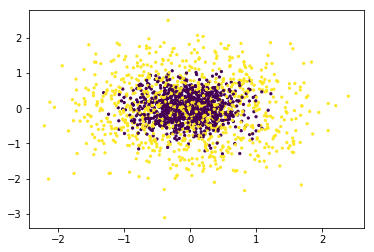

In [89]:
f,l=kolko_w_kolku()
rysoj_dane(f,l)
def generator(f,l):
    for i in range(len(f)):
        yield {'dwuwektor':f[i],'losowa':np.random.randn()},l[i]

In [90]:
dane=generator(f,l)

In [91]:
next(dane)

({'dwuwektor': array([ 0.89984345, -0.74954184]), 'losowa': 0.530912697873297},
 0)

In [92]:
a=Io_tf_binary_stary('dane_treningowe2',{'dwuwektor':(2,'f'),'losowa':(1,'f')})

In [93]:
#a.wpisz(dane)
for f,l in dane:
    a.wpisz(f,l)

In [94]:
a.close()

In [95]:
dataset=a.wczytaj_dataset()

{'dwuwektor': FixedLenFeature(shape=[2], dtype=tf.float32, default_value=None), 'losowa': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}


In [97]:

BATCH_SIZE=2
zbachowany=dataset.shuffle(1000).repeat().batch(BATCH_SIZE)
iterator = zbachowany.make_one_shot_iterator()
f,l=iterator.get_next()

with tf.Session() as sess:
    for i in range(100):
        print(sess.run([f,l]))


[{'dwuwektor': array([[-0.20045918, -0.24493715],
       [ 0.02171228, -0.02263291]], dtype=float32), 'losowa': array([[-0.8414467],
       [-1.4652964]], dtype=float32)}, array([0, 0])]
[{'dwuwektor': array([[ 1.2397883 ,  1.2721387 ],
       [-0.04336775, -0.17293163]], dtype=float32), 'losowa': array([[-1.781176 ],
       [-0.8123052]], dtype=float32)}, array([1, 0])]
[{'dwuwektor': array([[ 0.34080407, -0.37017632],
       [ 0.8161611 ,  0.7767115 ]], dtype=float32), 'losowa': array([[0.9961212],
       [0.0777107]], dtype=float32)}, array([0, 1])]
[{'dwuwektor': array([[ 0.29148772,  0.10289205],
       [-0.8009902 , -0.54375625]], dtype=float32), 'losowa': array([[-0.15686284],
       [ 1.0579075 ]], dtype=float32)}, array([0, 1])]
[{'dwuwektor': array([[ 0.03076197,  0.01931539],
       [-0.20361257, -0.35023576]], dtype=float32), 'losowa': array([[-2.140725  ],
       [-0.82869846]], dtype=float32)}, array([1, 0])]
[{'dwuwektor': array([[-0.11176401,  0.12419438],
       [-0.93

In [63]:
a=np.array([1])

In [64]:
type(a[0])

numpy.int64